Testing Guney's `toolbox` package for network based proximity between drug targets and disease genes.

Chosen targets:
* Hydroxychloroquine targets (TLR7 and TLR9)
* two of the AD disease genes

AD disease genes:
* Guney AD genes: from Guney et al
* Knowledge based AD genes: from the DISEASES database
* High confidence AD genes: knowledge based + TWAS + incipient proteomic signature

Both choices of targets are rather arbitrary.  We expect the two AD disease genes, by definition, to be more proximal than the Hydroxychloroquine targets (which are not AD genes by any definition used in this notebook). The calculations below will support this quantitatively.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from toolbox import wrappers
from toolbox import network_utilities
import pandas as pd
import numpy as np
import scipy.stats
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
import seaborn as sns
import attila_utils
import repos_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GenRev not found, steiner wont work
Import error: Negex. Using keyword matching instead
Import error: Funcassociate. Make sure that funcassociate is in toolbox!


## Preparations

### GeneID -- Symbol mapping

`id_mapping_file` comes from [this file](ftp://ftp.ncbi.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz) at NCBI; see [parse_ncbi.py](https://github.com/attilagk/guney_code/blob/master/parse_ncbi.py) for details.

In [2]:
id_mapping_file = '../../resources/PPI/geneid_to_symbol.txt'
id_symbol = pd.read_csv(id_mapping_file, sep='\t', index_col='GeneID')
id_symbol = id_symbol.set_index(id_symbol.index.astype('str'))
id_symbol

,Symbol
GeneID,
1,A1BG
2,A2M
3,A2MP1
9,NAT1
10,NAT2
...,...
8923215,trnD
8923216,trnP
8923217,trnA


### PPI networks

I read two PPI networks:
1. `network_guney` from Guney et al 2016
1. `network_cheng` from Cheng et al 2019

Below is the number of binary PPI interactions in each of these networks

In [3]:
%%bash
wc -l ../../resources/proximity/data/network/network.sif ../../resources/PPI/Cheng2019/network.sif

  141296 ../../resources/proximity/data/network/network.sif
  217160 ../../resources/PPI/Cheng2019/network.sif
  358456 total


Let's get the number of genes:

In [30]:
%%bash
for f in ../../resources/{proximity/data/network,PPI/Cheng2019}/network.sif; do
#for f in ../../resources/proximity/data/network/network.sif ../../resources/PPI/Cheng2019/network.sif; do
    sed 's/^\([0-9]*\) .*$/\1/' $f | sort -u | wc -l
done

   11117
   11133


In [4]:
network_guney = wrappers.get_network('../../resources/proximity/data/network/network.sif', only_lcc = True)
network_cheng = wrappers.get_network('../../resources/PPI/Cheng2019/network.sif', only_lcc = True)

### HCQ targets
I will use Hydroxychloroquine's targets.  See [this page](https://go.drugbank.com/drugs/DB01611) on drugbank.

In [5]:
%%bash
echo TLR7 > ../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets
echo TLR9 >> ../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets

In [6]:
HCQ_targets_TLR = wrappers.convert_to_geneid(file_name='../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets', id_type='symbol', id_mapping_file=id_mapping_file)
HCQ_targets_TLR

set()


{'51284', '54106'}

In [7]:
%%bash
echo ACE2 >> ../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets

In [8]:
HCQ_targets = wrappers.convert_to_geneid(file_name='../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets', id_type='symbol', id_mapping_file=id_mapping_file)
HCQ_targets

set()


{'51284', '54106', '59272'}

### AD gene sets
#### Guney AD genes

In [9]:
%%bash
grep 'alzheimer disease' ../../resources/proximity/data/disease/disease_genes.tsv | \
tr '\t' '\n' | sed -n '/^[0-9]\+/ p' > ../../results/2021-08-04-guney-tools/AD-genes-guney

In [10]:
with open('../../results/2021-08-04-guney-tools/AD-genes-guney') as f:
    AD_genes_guney = f.readlines()
AD_genes_guney = [x.strip('\n') for x in AD_genes_guney]

Making sure that the gene set is a subset of the network's nodes

In [11]:
def remove_genes_notin_network(genes, network):
    oldsize = len(genes)
    newgenes = [y for y in genes if y in network.nodes]
    newsize = len(newgenes)
    restgenes = set(genes).difference(set(newgenes))
    print(oldsize - newsize, 'genes removed from', oldsize)
    return((newgenes, restgenes))

AD_genes_guney, AD_genes_guney_removed = remove_genes_notin_network(AD_genes_guney, network_cheng)

0 genes removed from 0


When I use the older, smaller `network_guney` then additional genes are removed (therefore I won't use `network_guney`).

In [12]:
AD_genes_guney1, AD_genes_guney_removed1 = remove_genes_notin_network(AD_genes_guney, network_guney)

0 genes removed from 0


In [13]:
gset_names = ['knowledge', 'knowledge-TWAS2plus', 'knowledge-TWAS', 'knowledge-TWAS2plus-IAPS']
def read_geneset(name):
    file_name = '../../results/2021-07-01-high-conf-ADgenes/AD-genes-' + name
    gset = wrappers.convert_to_geneid(file_name=file_name, id_type='symbol', id_mapping_file=id_mapping_file)
    gset, gset_dropped = repos_tools.drop_genes_notin_network(gset, network_cheng)
    return(gset)

Genesets = {k: read_geneset(k) for k in gset_names}
Genesets.update({'Guney': AD_genes_guney})

{'MT-ND2', 'MT-ND1'}
{'CTB-129P6.11', 'MT-ND2', 'GATS', 'MT-ND1'}
{'CTB-129P6.11', 'MT-ND2', 'MT-ND1', 'GATS', 'AC087500.1', 'FAM115D', 'RTFDC1', 'CTD-2380F24.1', 'RP11-385F7.1', 'ENSG00000270081.1', 'AC099524.1', 'ENSG00000260911', 'X84075', 'AL512631.1'}
{'CTB-129P6.11', 'MT-ND2', 'GATS', 'MT-ND1'}


## Results

### Overlap between AD gene sets

Relationship of various AD gene sets are plotted below

['named-figure/AD-gene-sets-venn2.png', 'named-figure/AD-gene-sets-venn2.pdf']

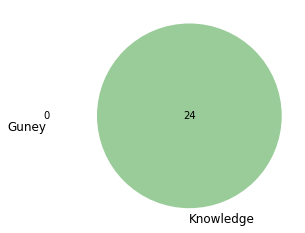

In [14]:
G = set(Genesets['Guney'])
K = set(Genesets['knowledge'])
H = set(Genesets['knowledge-TWAS2plus'])

def get_subsets2(A, B):
    partition = dict()
    partition['10'] = A.difference(B)
    partition['01'] = B.difference(A)
    partition['11'] = A.intersection(B)
    subsets = {k: len(v) for k, v in partition.items()}
    return(subsets)

fig, ax = plt.subplots()
subsets = get_subsets2(A=set(Genesets['Guney']), B=set(Genesets['knowledge']))
venn2(subsets=subsets, set_labels=('Guney', 'Knowledge'))
attila_utils.savefig(fig, 'AD-gene-sets-venn2')

The intersection contains APP, APOE and PSEN1, PSEN2.

written to AD-gene-sets-venn3-TWAS2plus


/usr/local/anaconda3/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")


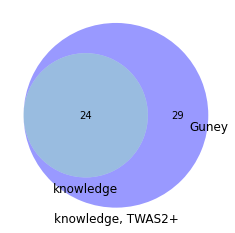

In [15]:
def get_subsets3(A, B, C):
    partition = dict()
    partition['100'] = A.difference(B.union(C))
    partition['010'] = B.difference(A.union(C))
    partition['001'] = C.difference(A.union(B))
    partition['110'] = A.intersection(B).difference(C)
    partition['101'] = A.intersection(C).difference(B)
    partition['011'] = B.intersection(C).difference(A)
    partition['111'] = A.intersection(B).intersection(C)
    subsets = {k: len(v) for k, v in partition.items()}
    return(subsets)

def plot_subsets3(Cname='TWAS2plus', Lname='TWAS2+'):
    fig, ax = plt.subplots()
    subsets = get_subsets3(A=set(Genesets['Guney']), B=set(Genesets['knowledge']), C=set(Genesets['knowledge-' + Cname]))
    venn3(subsets=subsets, set_labels=('Guney', 'knowledge', 'knowledge, ' + Lname))
    fname = 'AD-gene-sets-venn3-' + Cname
    attila_utils.savefig(fig, fname)
    print('written to', fname)

plot_subsets3(Cname='TWAS2plus', Lname='TWAS2+')

/usr/local/anaconda3/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")


written to AD-gene-sets-venn3-TWAS


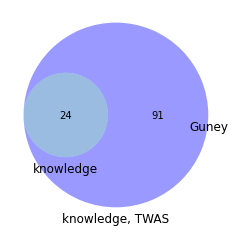

In [16]:
plot_subsets3(Cname='TWAS', Lname='TWAS')

written to AD-gene-sets-venn3-TWAS2plus-IAPS


/usr/local/anaconda3/lib/python3.8/site-packages/matplotlib_venn/_venn3.py:53: UserWarning: Circle A has zero area
  warnings.warn("Circle A has zero area")


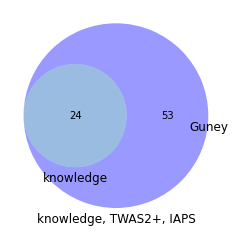

In [17]:
plot_subsets3(Cname='TWAS2plus-IAPS', Lname='TWAS2+, IAPS')

### Node degree

In [18]:
G_knowledge = network_utilities.get_neighborhood_subgraph(network_cheng, Genesets['knowledge'])
degrees_knowledge = network_utilities.get_node_degree_related_values(G_knowledge, set())

In [19]:
dk = pd.DataFrame(degrees_knowledge).transpose().rename({0: 'd', 1: 'ld', 2: 'd2', 3: 'ld2'}, axis=1)
ik = id_symbol.loc[list(set(Genesets['Guney']).intersection(set(Genesets['knowledge']))), ]
pd.concat([ik, dk.loc[ik.index, ]], axis=1)

,Symbol,d,ld,d2,ld2
GeneID,,,,,


Now the same for all knowledge based genes

In [20]:
ik = id_symbol.loc[list(set(Genesets['knowledge'])), ]
d_knowledge = pd.concat([ik, dk.loc[ik.index, ]], axis=1)
d_knowledge = d_knowledge.rename(d_knowledge.Symbol, axis=0)
d_knowledge = d_knowledge.sort_values('d').drop(['Symbol', 'ld', 'd2', 'ld2'], axis=1)
d_knowledge = d_knowledge.rename_axis('')

['named-figure/degree-knowledge.png', 'named-figure/degree-knowledge.pdf']

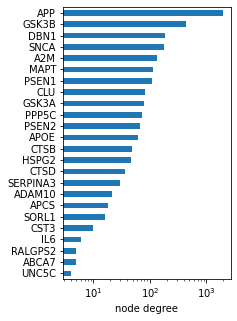

In [21]:
def my_degree_plot(color_3genes=False):
    fig, ax = plt.subplots(figsize=(3, 5))
    ax.set_xlabel('node degree')
    d_knowledge.plot(kind='barh', legend=False, logx=True, ax=ax)
    if color_3genes:
        for g in ['APOE', 'ABCA7', 'RALGPS2']:
            ax.patches[d_knowledge.index.to_list().index(g)].set_facecolor('red')
    return((fig, ax))

fig, ax = my_degree_plot(color_3genes=False)
attila_utils.savefig(fig, 'degree-knowledge')

['named-figure/degree-knowledge-3genes.png',
 'named-figure/degree-knowledge-3genes.pdf']

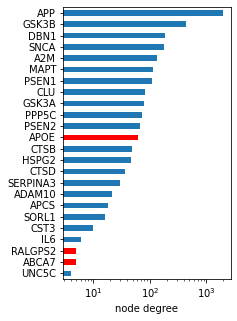

In [22]:
fig, ax = my_degree_plot(color_3genes=True)
attila_utils.savefig(fig, 'degree-knowledge-3genes')

In [23]:
G_HCQ = network_utilities.get_neighborhood_subgraph(network_cheng, HCQ_targets)
degrees_HCQ = network_utilities.get_node_degree_related_values(G_HCQ, set())

Let's calculate the degree of TLR7 and TLR9!

In [24]:
dh = pd.DataFrame(degrees_HCQ).transpose().rename({0: 'd', 1: 'ld', 2: 'd2', 3: 'ld2'}, axis=1)
ih = id_symbol.loc[HCQ_targets, ]
pd.concat([ih, dh.loc[ih.index, ]], axis=1)

,Symbol,d,ld,d2,ld2
GeneID,,,,,
59272,ACE2,5,0,10,0
54106,TLR9,28,0,33,0
51284,TLR7,6,0,19,0


I select ABCA7, APOE, and RALGPS2, three AD genes with comparable degrees to TLR7, TLR9, and ACE2, respectively:

In [25]:
AD_3genes = {'10347', '348', '55103'}
Targets = {'HCQ targets': HCQ_targets, 'HCQ t: TLRs': HCQ_targets_TLR, '3 AD genes': AD_3genes}

### Proximity

Now the proximity calculation between `HCQ_targets` and `AD_genes_guney`

## TODO

* Download and parse drugbank. See [drugbank-downloader](https://pypi.org/project/drugbank-downloader/)
* deploy `wrappers.calculate_proximity` to cloud

In [ ]:
%connect_info